In [1]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
import imutils
import glob
import csv
import random

In [2]:
def rotate(image, angle, center = None, scale = 1):
    (h, w) = image.shape[:2]
    if center is None:
        center = (w / 2, h / 2)
    M = cv2.getRotationMatrix2D(center, angle, scale)
    rotated = cv2.warpAffine(image, M, (w, h))
    return rotated

In [3]:
def order_points(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform(image, pts):

    rect = order_points(pts)
    (tl, tr, br, bl) = rect

    widthA = np.sqrt(((br[0] - bl[0]) ** 2) + ((br[1] - bl[1]) ** 2))
    widthB = np.sqrt(((tr[0] - tl[0]) ** 2) + ((tr[1] - tl[1]) ** 2))
    maxWidth = max(int(widthA), int(widthB))

    heightA = np.sqrt(((tr[0] - br[0]) ** 2) + ((tr[1] - br[1]) ** 2))
    heightB = np.sqrt(((tl[0] - bl[0]) ** 2) + ((tl[1] - bl[1]) ** 2))
    maxHeight = max(int(heightA), int(heightB))

    dst = np.array([
        [0, 0],
        [maxWidth - 1, 0],
        [maxWidth - 1, maxHeight - 1],
        [0, maxHeight - 1]], dtype = "float32")

    M = cv2.getPerspectiveTransform(rect, dst)
    warped = cv2.warpPerspective(image, M, (maxWidth, maxHeight))
    warped = cv2.resize(warped, (1000, 600))
    return tl, tr, br, bl, warped

In [4]:
def order_points2(pts):
    rect = np.zeros((4, 2), dtype = "float32")

    s = pts.sum(axis = 1)
    rect[0] = pts[np.argmin(s)]
    rect[2] = pts[np.argmax(s)]

    diff = np.diff(pts, axis = 1)
    rect[1] = pts[np.argmin(diff)]
    rect[3] = pts[np.argmax(diff)]

    return rect

def four_point_transform2(image, pts):

    rect = order_points2(pts)
    (tl, tr, br, bl) = rect
    return tl, tr, br, bl

def preprocess2(img):
    img = img.astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    kernel = np.ones((5,5),np.uint8)
    erosion = cv2.dilate(gray,kernel,iterations = 1)
    gau = cv2.GaussianBlur(erosion, (5, 5), 0)
    edged = cv2.Canny(gau, 150, 200)
    cnts = cv2.findContours(edged.copy(), cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv2.contourArea, reverse = True)[:5]
    # loop over the contours
    for c in cnts:
        # approximate the contour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.05 * peri, True)
        # if our approximated contour has four points, then we
        # can assume that we have found our screen
        if len(approx) == 4:
            screenCnt = approx
#             print(type(screenCnt))
#             print(screenCnt)
            break
        else:
            screenCnt = np.array([[0,0], [0, 0], [0,0], [0, 0]])
            

    tl, tr, br, bl = four_point_transform2(img.copy(), screenCnt.reshape(4, 2))
    return tl, tr, br, bl, edged


In [5]:
def add_white_border(image, border_size):

    # Calculate the new dimensions
    height, width, _ = image.shape
    new_width = width + (2 * border_size)
    new_height = height + (2 * border_size)

    # Create a new white background image
    bordered_image = cv2.copyMakeBorder(image, border_size, border_size, 
                                                border_size, border_size, 
                                                cv2.BORDER_CONSTANT, value=(255, 255, 255))

    return bordered_image

In [6]:
path_bg = r"C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\*"
path_img = r"C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\all_card\*"
a = 0

#     print(h, w)\
for image in glob.glob(path_img):
    
    for file in glob.glob(path_bg):
        print(file)
        flipp = [-1, 0, 1]
        fl = random.choice(flipp)
        bg = cv2.imread(file)
        bg = cv2.flip(bg, fl)
        h, w, _ = bg.shape
        black_bg = np.zeros((h, w, 3))

        img = cv2.imread(image)
        h_, w_, _ = img.shape
        border_size = 10
        img_border = add_white_border(img, border_size)

        #resize card
        abc = np.random.uniform(0.3, 0.4)
        w_new = int(w*abc)
        h_new = int(h_*(w_new/w_))

        out_auto = cv2.resize(img, (w_new, h_new) )
        out_auto2 = cv2.resize(img_border, (w_new, h_new) )
        h_, w_, _ = out_auto.shape


        x_min = int(w*0.15)
        y_min = int(h*0.15)
        x_max = int(w*0.45)
        y_max = int(h*0.45)
        x1 = np.random.randint(x_min, x_max)
        y1 = np.random.randint(y_min, y_max)


        #add card in bg
        if  (y1+h_) < h:
            bg[y1:y1+h_ , x1:x1+w_] = out_auto
            black_bg[y1:y1+h_ , x1:x1+w_] = out_auto2
        
        else:
            continue

        # rotate img
        angle = np.random.randint(-15,15)
        out_bg = rotate(bg, angle)
        h,w,_ = out_bg.shape
        out_bg_black = rotate(black_bg, angle)

        # Tranform img (làm méo hình)
        flexible = np.random.uniform(0.85,1.15)
        input_pts = np.float32([[0, 0],[w*flexible, 0],[w*flexible, h],[0, h*flexible]])
        output_pts = np.float32([[0, 0], [w, 0], [w, h], [0, h]])
        M = cv2.getPerspectiveTransform(input_pts,output_pts)
        out1 = cv2.warpPerspective(out_bg.copy(),M,(w, h),flags=cv2.INTER_LINEAR)
        out2 = cv2.warpPerspective(out_bg_black.copy(),M,(w, h),flags=cv2.INTER_LINEAR)

        fi = str(a)
        path_save1 = "C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/output1/" + fi + ".jpg"
        cv2.imwrite(path_save1, out1)
#         path_save2 = "C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/output2/" + fi + ".jpg"
#         cv2.imwrite(path_save2, out2)

        tl, tr, br, bl, canny = preprocess2(out2)
#         path_save2 = "C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/output1/" + fi + "_canny.jpg"
#         cv2.imwrite(path_save2, canny)

        tl = tl / np.array([w, h])
#         print(tl, type(tl))
        tr = tr / np.array([w, h])
        bl = bl / np.array([w, h])
        br = br / np.array([w, h])
        
        tl = [round(num, 3) for num in tl]
        tr = [round(num, 3) for num in tr]
        bl = [round(num, 3) for num in bl]
        br = [round(num, 3) for num in br]
        abc = []
        abc.append(tl)
        abc.append(tr)
        abc.append(br)
        abc.append(bl)



        csv_filename = 'points1.csv'

        # Open the CSV file in write mode
        with open(csv_filename, 'a+', newline='') as csvfile:
            writer = csv.writer(csvfile)

            # Write the flattened list of coordinates as a single row
            writer.writerow([path_save1] + [coord for point in abc for coord in point]+ [1])

        a+=1
#         if a >= 2:
#             break

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\i

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\b

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CC

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\im

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\im

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CC

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCC

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\im

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\im

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCC

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\b

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\i

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\im

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\b

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\im

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a 

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\b

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a 

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\im

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\im

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43)

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (136).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (137).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (138).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (122).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (123).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (124).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (125).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (126).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (127).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (128).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (129).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (13).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (130).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (131).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (132).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (133).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (134).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (135).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (110).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (111).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (112).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (113).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (114).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (115).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (116).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (117).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (118).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (119).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (12).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (120).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (121).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (98).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (99).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (1).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (10).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (100).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (101).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (102).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (103).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (104).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (105).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (106).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (107).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (108).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (109).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (11).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\img

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (85).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (86).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (87).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (88).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (89).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (90).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (91).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (92).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (93).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (94).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (95).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (96).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (97).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (9

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (74).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (75).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (76).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (77).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (78).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (79).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (8).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (80).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (81).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (82).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (83).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (84

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (60).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (61).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (62).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (63).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (64).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (65).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (66).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (67).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (68).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (69).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (7).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (70).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (71).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (72).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (73

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (50).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (51).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (52).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (53).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (54).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (55).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (56).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (57).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (58).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (59).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (6

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (39).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (4).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (40).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (41).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (42).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (43).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (44).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (45).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (46).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (47).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (48).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (49).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (5

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (24).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (25).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (26).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (27).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (28).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (29).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (3).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (30).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (31).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (32).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (33).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (34).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (35).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (36).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (37).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (38

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (16).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (17).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (18).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (19).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpeg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (2).png
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (20).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (21).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (22).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (23).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (139).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (14).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\C

C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (140).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (141).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (142).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (143).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (144).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (145).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (146).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (147).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (148).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (149).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (15).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (150).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (151).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (152).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (153).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (154).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\bg\a (155).jpg
C:\Users\ADMIN\Desktop\Thay_Lam\

In [ ]:
# import cv2
# import numpy as np

# # Read the image
# image = cv2.imread(r"C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\add_text_CCCD1\0.jpg")

# contrast = 1. # Contrast control ( 0 to 127)
# brightness = np.random.randint(-80, 60) # Brightness control (0-100)

# out = cv2.addWeighted( image, contrast, image, 0, brightness)

# # Display the original and brightened images
# plt.subplot(1,2,1)
# plt.imshow(image)

# plt.subplot(1,2,2)
# plt.imshow(out)


In [4]:
# path = r"C:\Users\ADMIN\Desktop\Thay_Lam\CCCD\imgs\card\out_img_CMND\*"
# path_save = "C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/card/all_card/card_"

# card = 103
# for file in glob.glob(path):
#     image = cv2.imread(file)
#     contrast = 1. 
#     brightness = np.random.randint(-80, 60)
#     out = cv2.addWeighted( image, contrast, image, 0, brightness)
#     link = path_save + str(card) + '.jpg'
#     cv2.imwrite(link, out)
#     card += 1

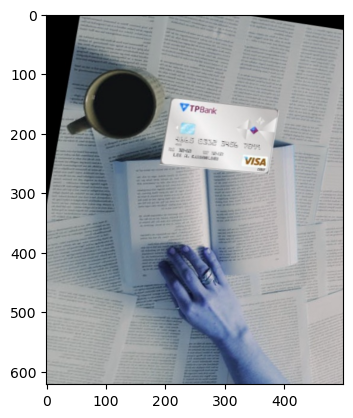

In [10]:
import cv2
# points = [0.378,0.294,0.722,0.423,0.664,0.732,0.328,0.588]
points = [0.414,0.223,0.784,0.256,0.75,0.436,0.378,0.41
]
path = 'C:/Users/ADMIN/Desktop/Thay_Lam/CCCD/imgs/output1/0.jpg'
img = cv2.imread(path)
h, w, _ = img.shape
plt.imshow(img)


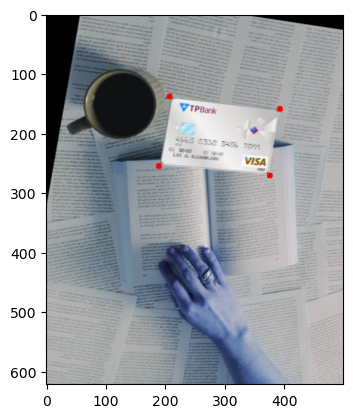

In [11]:
b = cv2.circle(img.copy(), (int(points[0]*w),int(points[1]*h)) , 5, (255,0,0), -1)
b = cv2.circle(b.copy(), (int(points[2]*w),int(points[3]*h)) , 5, (255,0,0), -1)
b = cv2.circle(b.copy(), (int(points[4]*w),int(points[5]*h)) , 5, (255,0,0), -1)
b = cv2.circle(b.copy(), (int(points[6]*w),int(points[7]*h)) , 5, (255,0,0), -1)
plt.imshow(b)

In [11]:
for i in range(10):
    if i == 5:
        continue
    else:
        print(i)

0
1
2
3
4
6
7
8
9
